In [4]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
import numbers

from PIL import Image
import math
from tqdm import tqdm

In [10]:
model_file_root = '../../models/'
model_file_ext = '.pt'
torch.manual_seed(42)

In [5]:
class RandomRotation:
    def __init__(self, degrees, resample=False, expand=False, center=None):
        if isinstance(degrees, numbers.Number):
            if degrees < 0:
                raise ValueError("If degrees is a single number, it must be positive.")
            self.degrees = (-degrees, degrees)
        else:
            if len(degrees) != 2:
                raise ValueError("If degrees is a sequence, it must be of len 2.")
            self.degrees = degrees

        self.resample = resample
        self.expand = expand
        self.center = center

    @staticmethod
    def get_params(degrees):
        angle = np.random.uniform(degrees[0], degrees[1])
        return angle

    def __call__(self, img):        
        def rotate(img, angle, resample=False, expand=False, center=None):
            return img.rotate(angle, resample, expand, center)

        angle = self.get_params(self.degrees)
        return rotate(img, angle, self.resample, self.expand, self.center)

In [6]:
class RandomShift(object):
    def __init__(self, shift):
        self.shift = shift
        
    @staticmethod
    def get_params(shift):
        hshift, vshift = np.random.uniform(-shift, shift, size=2)
        return hshift, vshift 
    
    def __call__(self, img):
        hshift, vshift = self.get_params(self.shift)
        return img.transform(img.size, Image.AFFINE, (1,0,hshift,0,1,vshift), resample=Image.BICUBIC, fill=1)

In [7]:
training_dataset = datasets.MNIST(root='data', train=True, download=True, transform=transforms.Compose([
    RandomRotation(degrees=20), 
    RandomShift(3),
    transforms.ToTensor(), 
    transforms.Normalize(mean=(0.5,), std=(0.5,))
]))

validation_dataset = datasets.MNIST(root='data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize(mean=(0.5,), std=(0.5,))
]))

In [8]:
training_dataset, validation_dataset

(Dataset MNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.5,), std=(0.5,))
            ), Dataset MNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.5,), std=(0.5,))
            ))

In [9]:
training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100, shuffle=True)

## 1. Simple Conv Net

In [12]:
class SimpleConvNet(nn.Module):
    
    def __init__(self):
        super(SimpleConvNet, self).__init__()    
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 20, 5, 1),        
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2),  
            nn.Conv2d(20, 50, 5, 1),
            nn.BatchNorm2d(50),
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2)  
        )
        self.full_conn_layers = nn.Sequential(
            nn.Linear(4*4*50, 500),        
            nn.ReLU(),
            nn.Linear(500, 10)         
        )
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.full_conn_layers(x)
        return x
    

In [13]:
model = SimpleConvNet()
epochs = 15
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [14]:
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []
 
for e in range(epochs):
  
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
  
    for inputs, labels in training_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
 
    else:
        with torch.no_grad():
            for val_inputs, val_labels in validation_loader:
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
        
                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels.data)
      
        epoch_loss = running_loss/len(training_loader)
        epoch_acc = running_corrects.float()/ len(training_loader)
        running_loss_history.append(epoch_loss)
        running_corrects_history.append(epoch_acc)

        val_epoch_loss = val_running_loss/len(validation_loader)
        val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc)
        print('epoch :', (e+1))
        print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
        print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

epoch : 1
training loss: 0.6453, acc 81.9650 
validation loss: 0.0914, validation acc 97.8400 
epoch : 2
training loss: 0.1862, acc 94.6600 
validation loss: 0.0628, validation acc 98.3100 
epoch : 3
training loss: 0.1325, acc 96.0933 
validation loss: 0.0549, validation acc 98.3900 
epoch : 4
training loss: 0.1090, acc 96.7850 
validation loss: 0.0389, validation acc 98.9100 
epoch : 5
training loss: 0.0939, acc 97.2383 
validation loss: 0.0364, validation acc 98.9300 
epoch : 6
training loss: 0.0852, acc 97.5500 
validation loss: 0.0311, validation acc 99.2100 
epoch : 7
training loss: 0.0774, acc 97.6017 
validation loss: 0.0306, validation acc 99.1000 
epoch : 8
training loss: 0.0700, acc 97.8967 
validation loss: 0.0297, validation acc 99.1500 
epoch : 9
training loss: 0.0642, acc 98.0217 
validation loss: 0.0272, validation acc 99.1900 
epoch : 10
training loss: 0.0600, acc 98.0900 
validation loss: 0.0250, validation acc 99.2400 
epoch : 11
training loss: 0.0559, acc 98.2867 
va

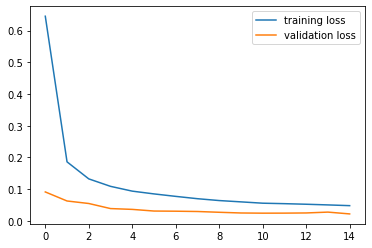

In [15]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

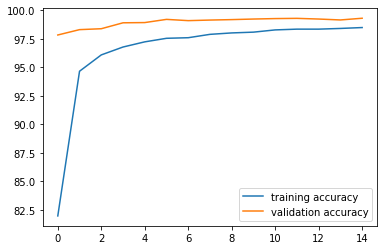

In [16]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

In [ ]:
path = model_file_root+'SimpleConvNet'+model_file_ext
torch.save(model.state_dict(), path)


# model = SimpleConvNet(*args, **kwargs)
# model.load_state_dict(torch.load(PATH))
# model.eval()

## 2. Simple Conv Net with decay learning rate

In [51]:
class SimpleConvNetLR(nn.Module):
    
    def __init__(self):
        super(SimpleConvNetLR, self).__init__()    
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 20, 5, 1),        
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2),  
            nn.Conv2d(20, 50, 5, 1),
            nn.BatchNorm2d(50),
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2)  
        )
        self.full_conn_layers = nn.Sequential(
            nn.Linear(4*4*50, 500),        
            nn.ReLU(),
            nn.Linear(500, 10)         
        )
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.full_conn_layers(x)
        return x
    

In [52]:
model = SimpleConvNetLR()
epochs = 20
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

In [53]:
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []
 
for e in range(epochs):
  
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
  
    print('epoch :', (e+1), 'LR:', scheduler.get_lr())
    for inputs, labels in training_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
 
    else:
        with torch.no_grad():
            for val_inputs, val_labels in validation_loader:
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
        
                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels.data)
      
        epoch_loss = running_loss/len(training_loader)
        epoch_acc = running_corrects.float()/ len(training_loader)
        running_loss_history.append(epoch_loss)
        running_corrects_history.append(epoch_acc)

        val_epoch_loss = val_running_loss/len(validation_loader)
        val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc)
        
        print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
        print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))
        scheduler.step()


epoch : 1 LR: [0.01]
training loss: 0.2957, acc 91.2717 
validation loss: 0.0547, validation acc 98.3000 
epoch : 2 LR: [0.01]
training loss: 0.0995, acc 96.9150 
validation loss: 0.0349, validation acc 98.9000 
epoch : 3 LR: [0.01]
training loss: 0.0754, acc 97.7200 
validation loss: 0.0419, validation acc 98.7000 
epoch : 4 LR: [0.01]
training loss: 0.0694, acc 97.8667 
validation loss: 0.0400, validation acc 98.7500 
epoch : 5 LR: [0.001]
training loss: 0.0445, acc 98.6150 
validation loss: 0.0183, validation acc 99.4200 
epoch : 6 LR: [0.001]
training loss: 0.0358, acc 98.8200 
validation loss: 0.0177, validation acc 99.4400 
epoch : 7 LR: [0.001]
training loss: 0.0331, acc 98.9933 
validation loss: 0.0171, validation acc 99.4500 
epoch : 8 LR: [0.001]
training loss: 0.0319, acc 99.0150 
validation loss: 0.0174, validation acc 99.4600 
epoch : 9 LR: [0.00010000000000000002]
training loss: 0.0295, acc 99.0700 
validation loss: 0.0159, validation acc 99.4700 
epoch : 10 LR: [0.000100

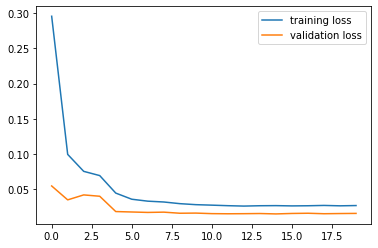

In [54]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

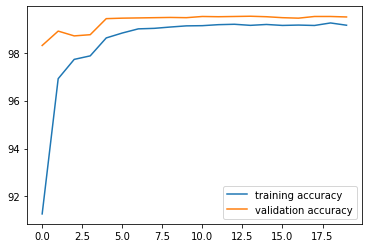

In [55]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

In [56]:
path = model_file_root+'SimpleConvNetLR'+model_file_ext
torch.save(model.state_dict(), path)


# model = SimpleConvNet(*args, **kwargs)
# model.load_state_dict(torch.load(PATH))
# model.eval()

## 2. Simple Conv Net with cyrcle learning rate

In [105]:
class SimpleConvNetCLR(nn.Module):
    
    def __init__(self):
        super(SimpleConvNetCLR, self).__init__()    
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 20, 5, 1),        
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2),  
            nn.Conv2d(20, 50, 5, 1),
            nn.BatchNorm2d(50),
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2)  
        )
        self.full_conn_layers = nn.Sequential(
            nn.Linear(4*4*50, 500),        
            nn.ReLU(),
            nn.Linear(500, 10)         
        )
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.full_conn_layers(x)
        return x
    

In [106]:
model = SimpleConvNetCLR()
epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.CyclicLR(
    optimizer,
    base_lr=1e-5, 
    max_lr=0.01,
    step_size_up=100,
    mode="exp_range", 
    gamma=0.998,
    cycle_momentum=False,
    last_epoch=-1,
)

In [107]:
%%time

running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []
lr_history = []

for e in range(epochs):
  
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
  
    print('epoch :', (e+1))
    for inputs, labels in training_loader:
        lr_history.append(scheduler.get_lr())
        outputs = model(inputs)
        loss = criterion(outputs, labels)
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
 
    else:
        with torch.no_grad():
            for val_inputs, val_labels in validation_loader:
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
        
                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels.data)

        epoch_loss = running_loss/len(training_loader)
        epoch_acc = running_corrects.float()/ len(training_loader)
        running_loss_history.append(epoch_loss)
        running_corrects_history.append(epoch_acc)

        val_epoch_loss = val_running_loss/len(validation_loader)
        val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc)
        
        print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
        print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))


epoch : 1
training loss: 0.2322, acc 92.6000 
validation loss: 0.0357, validation acc 98.8300 
epoch : 2
training loss: 0.0693, acc 97.8567 
validation loss: 0.0266, validation acc 99.1900 
epoch : 3
training loss: 0.0526, acc 98.3650 
validation loss: 0.0228, validation acc 99.2900 
epoch : 4
training loss: 0.0459, acc 98.5533 
validation loss: 0.0220, validation acc 99.2900 
epoch : 5
training loss: 0.0438, acc 98.6150 
validation loss: 0.0214, validation acc 99.3800 
epoch : 6
training loss: 0.0417, acc 98.7550 
validation loss: 0.0215, validation acc 99.3100 
epoch : 7
training loss: 0.0406, acc 98.7267 
validation loss: 0.0216, validation acc 99.3000 
epoch : 8
training loss: 0.0417, acc 98.6850 
validation loss: 0.0216, validation acc 99.2900 
epoch : 9
training loss: 0.0407, acc 98.7133 
validation loss: 0.0215, validation acc 99.3300 
epoch : 10
training loss: 0.0417, acc 98.7133 
validation loss: 0.0213, validation acc 99.2900 
CPU times: user 1h 13min 36s, sys: 48.7 s, total:

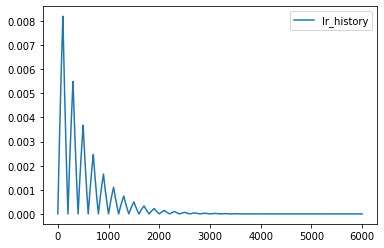

In [108]:
plt.plot(lr_history, label='lr_history')
plt.legend()

6.0708251442253465e-06

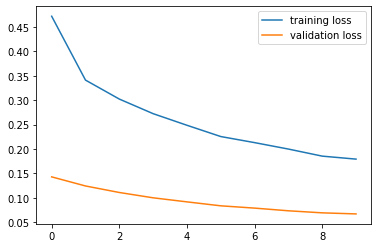

In [97]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

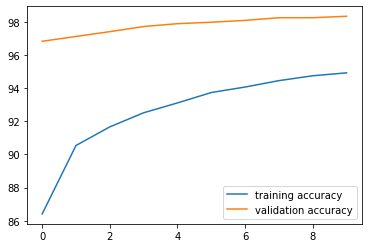

In [98]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

In [84]:
path = model_file_root+'SimpleConvNetCLR'+model_file_ext
torch.save(model.state_dict(), path)

# model = SimpleConvNet(*args, **kwargs)
# model.load_state_dict(torch.load(PATH))
# model.eval()

## 2. Simple Conv Net with plato learning rate

In [130]:
class SimpleConvNetPLR(nn.Module):
    
    def __init__(self):
        super(SimpleConvNetPLR, self).__init__()    
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 20, 5, 1),        
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2),  
            nn.Conv2d(20, 50, 5, 1),
            nn.BatchNorm2d(50),
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2)  
        )
        self.full_conn_layers = nn.Sequential(
            nn.Linear(4*4*50, 500),        
            nn.ReLU(),
            nn.Linear(500, 10)         
        )
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.full_conn_layers(x)
        return x
    

In [131]:
model = SimpleConvNetPLR()
epochs = 20
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    factor=0.3,
    mode="max",
    verbose=True,
    patience=1
)

In [119]:
%%time

running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
  
    print('epoch :', (e+1))
    for inputs, labels in training_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
 
    else:
        with torch.no_grad():
            for val_inputs, val_labels in validation_loader:
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
        
                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels.data)

        epoch_loss = running_loss/len(training_loader)
        epoch_acc = running_corrects.float()/ len(training_loader)
        running_loss_history.append(epoch_loss)
        running_corrects_history.append(epoch_acc)

        val_epoch_loss = val_running_loss/len(validation_loader)
        val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc)
        
        print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
        print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))
        scheduler.step(val_epoch_acc)
        

epoch : 1
training loss: 0.2707, acc 91.8217 
validation loss: 0.0429, validation acc 98.6500 
epoch : 2
training loss: 0.0955, acc 97.0300 
validation loss: 0.0402, validation acc 98.8900 
epoch : 3
training loss: 0.0753, acc 97.6917 
validation loss: 0.0293, validation acc 99.1200 
epoch : 4
training loss: 0.0671, acc 97.9400 
validation loss: 0.0327, validation acc 98.9500 
epoch : 5
training loss: 0.0662, acc 97.9700 
validation loss: 0.0367, validation acc 98.8600 
Epoch     4: reducing learning rate of group 0 to 3.0000e-03.
epoch : 6
training loss: 0.0388, acc 98.8133 
validation loss: 0.0211, validation acc 99.3900 
epoch : 7
training loss: 0.0345, acc 98.9400 
validation loss: 0.0198, validation acc 99.4500 
epoch : 8
training loss: 0.0316, acc 99.0267 
validation loss: 0.0197, validation acc 99.3900 
epoch : 9
training loss: 0.0325, acc 99.0050 
validation loss: 0.0213, validation acc 99.2900 
Epoch     8: reducing learning rate of group 0 to 9.0000e-04.
epoch : 10
training l

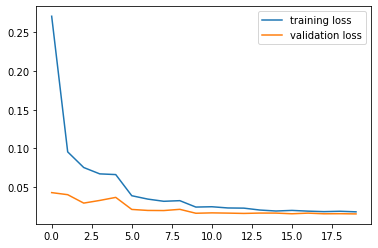

In [122]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

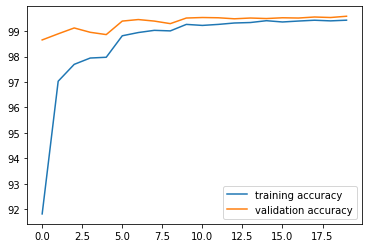

In [123]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

In [124]:
path = model_file_root+'SimpleConvNetPLR'+model_file_ext
torch.save(model.state_dict(), path)

# model = SimpleConvNet(*args, **kwargs)
# model.load_state_dict(torch.load(PATH))
# model.eval()

In [132]:
def train(model):
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
    model.train()
    
    for inputs, labels in training_loader:
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

    else:
        epoch_loss = running_loss/len(training_loader)
        epoch_acc = running_corrects.float()/ len(training_loader)
    
    return epoch_loss, epoch_acc

In [133]:
def evaluate(model):
    loss = 0.0
    corrects = 0.0
    
    model.eval()
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs, labels = Variable(inputs), Variable(labels)
            outputs = model(inputs)

            loss += F.cross_entropy(outputs, labels, reduction='mean').item()
            pred = outputs.data.max(1, keepdim=True)[1]
            corrects += pred.eq(labels.data.view_as(pred)).cpu().sum()
               
    return loss/len(validation_loader), corrects.float()/len(validation_loader)

In [134]:
%%time
n_epochs = 15

epoch_loss_history = []
epoch_corrects_history = []
val_loss_history = []
val_corrects_history = []

for epoch in range(n_epochs):
    epoch_loss, epoch_corrects = train(model)
    val_loss, val_corrects = evaluate(model)
    
    epoch_loss_history.append(epoch_loss)
    epoch_corrects_history.append(epoch_corrects)
    val_loss_history.append(val_loss)
    val_corrects_history.append(val_corrects)
    
    print('epoch :', (epoch+1))
    print('training loss: {:.4f}, training acc {:.4f} '.format(epoch_loss, epoch_corrects.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_loss, val_corrects.item()))
    scheduler.step(val_corrects)
    

epoch : 1
training loss: 0.2862, training acc 91.5483 
validation loss: 0.0524, validation acc 98.4100 
epoch : 2
training loss: 0.0963, training acc 97.0250 
validation loss: 0.0329, validation acc 98.9100 
epoch : 3
training loss: 0.0762, training acc 97.6100 
validation loss: 0.0275, validation acc 99.1000 
epoch : 4
training loss: 0.0668, training acc 97.9467 
validation loss: 0.0256, validation acc 99.1800 
epoch : 5
training loss: 0.0627, training acc 98.1700 
validation loss: 0.0226, validation acc 99.2000 
epoch : 6
training loss: 0.0598, training acc 98.1267 
validation loss: 0.0223, validation acc 99.2800 
epoch : 7
training loss: 0.0566, training acc 98.2850 
validation loss: 0.0258, validation acc 99.1800 
epoch : 8
training loss: 0.0532, training acc 98.4567 
validation loss: 0.0250, validation acc 99.2600 
Epoch     7: reducing learning rate of group 0 to 3.0000e-03.
epoch : 9
training loss: 0.0335, training acc 98.9867 
validation loss: 0.0172, validation acc 99.4900 
ep

KeyboardInterrupt: 

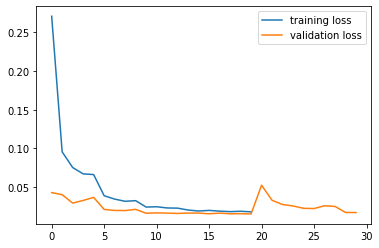

In [135]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

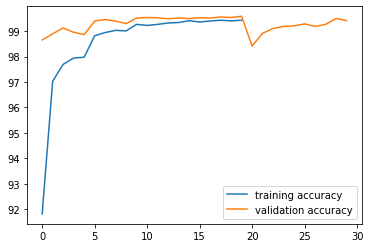

In [136]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

## 2. Conv2Class2Net

In [141]:
class Conv2Class2Net(nn.Module):
    def __init__(self):
        super(Conv2Class2Net, self).__init__()
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2)
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 7 * 7, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(0.3),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(0.3),
            
            nn.Linear(256, 10)
        )
        
        for m in self.cnn_layers.children():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        
        for m in self.fc_layers.children():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        
    def forward(self, x):
        out = self.cnn_layers(x)
        out = out.view(out.size(0), -1)
        out = self.fc_layers(out)
        return out

In [142]:
model = Conv2Class2Net()
epochs = 20
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    factor=0.3,
    mode="max",
    verbose=True,
    patience=1
)

In [143]:
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
              ReLU-3           [-1, 32, 28, 28]               0
            Conv2d-4           [-1, 32, 28, 28]           9,248
       BatchNorm2d-5           [-1, 32, 28, 28]              64
              ReLU-6           [-1, 32, 28, 28]               0
         MaxPool2d-7           [-1, 32, 14, 14]               0
           Dropout-8           [-1, 32, 14, 14]               0
            Conv2d-9           [-1, 64, 14, 14]          18,496
      BatchNorm2d-10           [-1, 64, 14, 14]             128
             ReLU-11           [-1, 64, 14, 14]               0
           Conv2d-12           [-1, 64, 14, 14]          36,928
      BatchNorm2d-13           [-1, 64, 14, 14]             128
             ReLU-14           [-1, 64,

In [144]:
%%time
n_epochs = 20

epoch_loss_history = []
epoch_corrects_history = []
val_loss_history = []
val_corrects_history = []

for epoch in range(n_epochs):
    epoch_loss, epoch_corrects = train(model)
    val_loss, val_corrects = evaluate(model)
    
    epoch_loss_history.append(epoch_loss)
    epoch_corrects_history.append(epoch_corrects)
    val_loss_history.append(val_loss)
    val_corrects_history.append(val_corrects)
    
    print('epoch :', (epoch+1))
    print('training loss: {:.4f}, training acc {:.4f} '.format(epoch_loss, epoch_corrects.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_loss, val_corrects.item()))
    
    path = f"{model_file_root}Conv2Class2Net_{epoch}{model_file_ext}"
    torch.save(model.state_dict(), path)

    scheduler.step(val_corrects)

epoch : 1
training loss: 0.2465, training acc 92.3367 
validation loss: 0.0300, validation acc 99.0200 
epoch : 2
training loss: 0.1106, training acc 96.6683 
validation loss: 0.0337, validation acc 98.9100 
epoch : 3
training loss: 0.0903, training acc 97.2633 
validation loss: 0.0304, validation acc 99.0100 
Epoch     2: reducing learning rate of group 0 to 3.0000e-03.
epoch : 4
training loss: 0.0610, training acc 98.1917 
validation loss: 0.0140, validation acc 99.5400 
epoch : 5
training loss: 0.0512, training acc 98.4183 
validation loss: 0.0182, validation acc 99.4700 
epoch : 6
training loss: 0.0509, training acc 98.4733 
validation loss: 0.0146, validation acc 99.5100 
Epoch     5: reducing learning rate of group 0 to 9.0000e-04.
epoch : 7
training loss: 0.0420, training acc 98.7500 
validation loss: 0.0118, validation acc 99.5600 
epoch : 8
training loss: 0.0381, training acc 98.8533 
validation loss: 0.0134, validation acc 99.6400 
epoch : 9
training loss: 0.0369, training ac

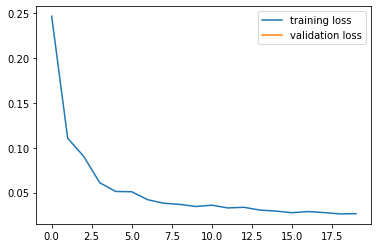

In [155]:
plt.plot(epoch_loss_history, label='training loss')
plt.plot(val_corrects_history, label='validation loss')
plt.legend()

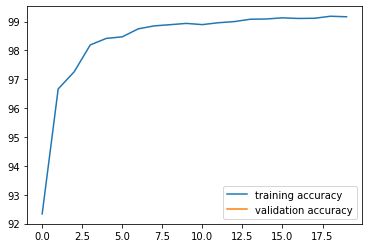

In [156]:
plt.plot(epoch_corrects_history, label='training accuracy')
plt.plot(val_corrects_history, label='validation accuracy')
plt.legend()

In [159]:
path = model_file_root+'Conv2Class2Net_16'+model_file_ext
# torch.save(model.state_dict(), path)

model = Conv2Class2Net()
model.load_state_dict(torch.load(path))
model.eval()

Conv2Class2Net(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

In [160]:
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
              ReLU-3           [-1, 32, 28, 28]               0
            Conv2d-4           [-1, 32, 28, 28]           9,248
       BatchNorm2d-5           [-1, 32, 28, 28]              64
              ReLU-6           [-1, 32, 28, 28]               0
         MaxPool2d-7           [-1, 32, 14, 14]               0
           Dropout-8           [-1, 32, 14, 14]               0
            Conv2d-9           [-1, 64, 14, 14]          18,496
      BatchNorm2d-10           [-1, 64, 14, 14]             128
             ReLU-11           [-1, 64, 14, 14]               0
           Conv2d-12           [-1, 64, 14, 14]          36,928
      BatchNorm2d-13           [-1, 64, 14, 14]             128
             ReLU-14           [-1, 64,

In [161]:
val_loss, val_corrects = evaluate(model)
print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_loss, val_corrects.item()))

validation loss: 0.0097, validation acc 99.7200 
